<div style="text-align:center">
    <h1>
        Advantage Actor-Critic (A2C)
    </h1>
</div>

<br><br>

<div style="text-align:center">
In this notebook we are going to combine temporal difference learning (TD) with policy gradient methods. The resulting algorithm is called Advantage Actor-Critic (A2C) and uses a one-step estimate of the return to update the policy:
</div>

\begin{equation}
\hat G_t = R_{t+1} + \gamma v(S_{t+1}|w)
\end{equation}


<br><br>
<div style="text-align:center">
    <b>This notebook belongs to section 10 of the course "Reinforcement Learning: beginner to master".</b>
    <br><br>
    <a href="https://www.udemy.com">Reinforcement Learning: beginner to master</a> (English)
    <br>
    <a href="https://www.udemy.com">Reinforcement Learning: de principiante a maestro</a> (Spanish)
</div>

<br>

<table style="width:35%">
  <tr style="background-color: transparent">
    <td style="width: 45%">
        <a target="_parent" href="https://www.evlabs.io" style="float: center">
            <img src="img/evlabs-square.png" width="75"/>
        </a> 
    </td>
    <td valign="bottom">
        <a target="_parent" href="https://www.youtube.com/channel/UCksRNSzWuMV5IfdrPlglqqw">
            <img src="img/YouTube.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://www.linkedin.com/company/evlabs">
            <img src="img/LinkedIn.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://twitter.com/evelabs">
            <img src="img/Twitter.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://github.com/escape-velocity-labs/">
            <img src="img/GitHub.png" width="35"/>
        </a> 
    </td>

  </tr>
  <tr style="background-color: transparent">
    <th style="text-align: center; width: 70%">Escape Velocity Labs</th>
  </tr>

</table>

<br>

## Import the necessary software libraries:

In [1]:
import os
import torch
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn as nn
from torch.optim import AdamW
import torch.nn.functional as F

from utils import test_policy_network, seed_everything, plot_stats
from parallel_env import ParallelEnv, ParallelWrapper

## Create and preprocess the environment

### Create the environment

In [2]:
env = gym.make('Acrobot-v1')

In [3]:
dims = env.observation_space.shape[0]
actions = env.action_space.n

print(f"State dimensions: {dims}. Actions: {actions}")
print(f"Sample state: {env.reset()}")

State dimensions: 6. Actions: 3
Sample state: [ 0.99916255  0.04091722  0.9955062   0.09469641  0.01487561 -0.00989374]


D:\Users\apytl\AppData\Anaconda3\envs\bmrl\lib\site-packages\pyglet\image\codecs\wic.py:406: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


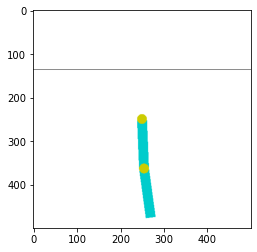

In [4]:
plt.imshow(env.render(mode='rgb_array'))

### Parallelize the environment

In [5]:
num_envs = os.cpu_count()

In [6]:
def create_env(env_name, seed):
    env = gym.make(env_name)
    seed_everything(env)
    
    return env

In [7]:
env_fns = [lambda: create_env('Acrobot-v1', seed=rank) for rank in range(num_envs)]
parallel_env =  ParallelEnv(env_fns)

### Prepare the environment to work with PyTorch

In [8]:
class PreprocessEnv(ParallelWrapper):
    
    def __init__(self, env):
        ParallelWrapper.__init__(self, env)
    
    def reset(self):
        state = self.venv.reset()
        return torch.from_numpy(state).float()
    
    def step_async(self, actions):
        actions = actions.squeeze().numpy()
        self.venv.step_async(actions)
     
    def step_wait(self):
        next_state, reward, done, info = self.venv.step_wait()
        next_state = torch.from_numpy(next_state).float()
        reward = torch.tensor(reward).unsqueeze(1).float()
        done = torch.tensor(done).unsqueeze(1)
        return next_state, reward, done, info

In [9]:
parallel_env = PreprocessEnv(parallel_env)

### Create the policy $\pi(s)$

In [10]:
policy =  nn.Sequential(
    nn.Linear(dims, 128),
    nn.ReLU(),
    
    nn.Linear(128, 64),
    nn.ReLU(),
    
    nn.Linear(64, actions), #-> [-inf, +Inf]-> [0, 1]
    nn.Softmax(dim=-1))

### Create the value network $v(s)$

In [11]:
value_net =  nn.Sequential(
    nn.Linear(dims, 128),
    nn.ReLU(),
    
    nn.Linear(128, 64),
    nn.ReLU(),
    
    nn.Linear(64, 1)) #only diff is that return a single value for a state we passes as as input. And the softmax func is not
#needed because this value can take any decimal value.


## Implement the algorithm

</br>

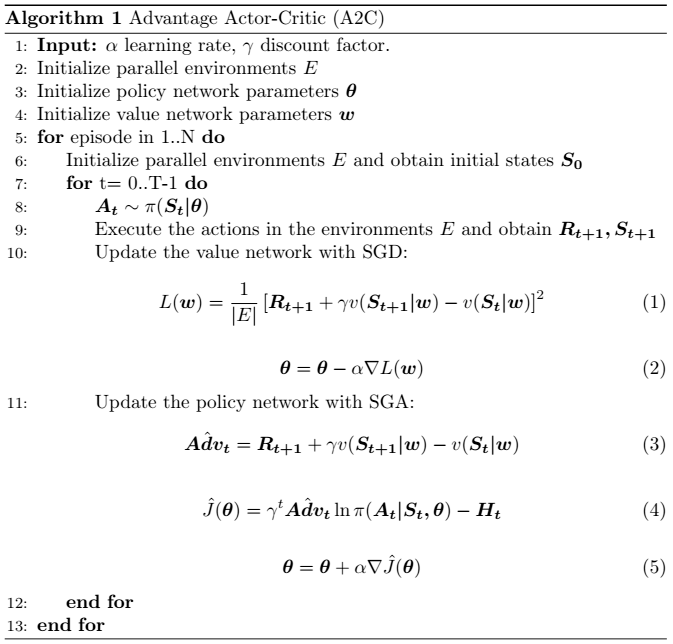

In [14]:
def actor_critic(policy, value_network, episodes, alpha=1e-4, gamma=.99):
    
    policy_optim = AdamW(policy.parameters(), lr=alpha)
    value_optim =  AdamW(value_net.parameters(), lr=alpha)
    stats = {'Actor Loss': [], 'Critic Loss': [], 'Returns': []}
    
    for episode in tqdm(range(1, episodes + 1)):
        state =  parallel_env.reset()
        done_b = torch.zeros((num_envs, 1), dtype=torch.bool) # to tell us each moment in time the envs that already finished
                #the episode and the ones the episode still going on
        ep_return  = torch.zeros((num_envs, 1)) # to store the returns obtained in each episode
        I =  1. # to help to implement gamma**t
        
        while not done_b.all():
        
            action = policy(state).multinomial(1).detach() #use the multinomial function to pick a single action based on those
            #probabilities. and detach() method to make sure that this tensor doesn't take part in theback propagation algorithm
            # that PyTorch will use to update the neural networks.
            
            #execute the actio on the env anc collect the result.
            next_state, reward, done, _ = parallel_env.step(action)
            
            #then use the experience collected to update the policy and the value network
            value =  value_net(state)
            target = reward + ~done * gamma * value_net(next_state).detach() # detach() because the estimated target does not
            #take part of the SGD. Only the present value estimate to take part
            
            critic_loss =  F.mse_loss(value, target) # MSE
            value_net.zero_grad() #delete the gradient stored in the value network
            critic_loss.backward() # trigger the back propagation to compute the gradient
            value_optim.step() # perform the update
            
            #next we need to update the policy network with SGA
            advantage = (target - value).detach()
            probs = policy(state)
            log_probs = torch.log(probs + 1e-6)
            action_log_prob = log_probs.gather(1, action) # gather ponly the prob of the action that we chose
            
            #compute the entropy
            entropy = - torch.sum(probs * log_probs, dim=-1, keepdim=True)
            
            #cost fucntion of the policy
            actor_loss = - I * action_log_prob * advantage - 0.01 * entropy # 0.01 is a small constant
            actor_loss =  actor_loss.mean()
            policy.zero_grad()
            actor_loss.backward()
            policy_optim.step()
            
            #update the variable
            ep_return += reward
            done_b |= done
            state = next_state
            i = I * gamma
        
        stats['Actor Loss'].append(actor_loss.item())
        stats['Critic Loss'].append(critic_loss.item())
        stats['Returns'].append(ep_return.mean().item())
    
    return stats
    
    

In [15]:
stats =  actor_critic(policy, value_net, 200)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [03:22<00:00,  1.01s/it]


## Show results

### Show execution stats

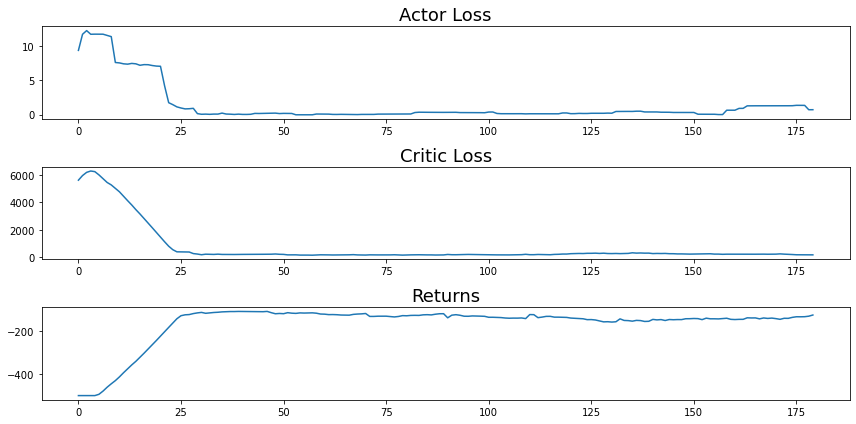

In [16]:
plot_stats(stats)

In [20]:
""" As you can see, the cost function for the value network has decreased steadily in the first episode.
That is so because in these episodes it learn to correctly estimate the values approaching their target values.

On the other hand, the policy has also obtained a dramatic increase in its performance.In these first episodes, as the 
Asian adopted the right actions, the returns have gone from the minimum,which is negative 300 to about negative one hundred
and twenty.That is, it was capable of finding a solution in about one hundred and twenty steps."""

' As you can see, the cost function for the value network has decreased steadily in the first episode.\nThat is so because in these episodes it learn to correctly estimate the values approaching their target values.\n\nOn the other hand, the policy has also obtained a dramatic increase in its performance.In these first episodes, as the \nAsian adopted the right actions, the returns have gone from the minimum,which is negative 300 to about negative one hundred\nand twenty.That is, it was capable of finding a solution in about one hundred and twenty steps.'

### Test the resulting agent

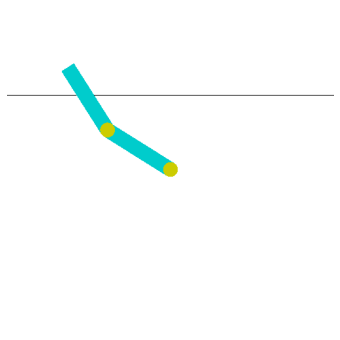

In [19]:
test_policy_network(env, policy, episodes=2)

In [ ]:
""" And as you can see, the agent is capable of touching the horizontal bar."""

## Resources

[[1] Reinforcement Learning: An Introduction. Ch.13](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf)